In [21]:
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [22]:
#_creating default figure size of matplotlib
plt.rcParams['figure.figsize'] = 10.0, 5.0

In [44]:
def plot_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values,x_label, y_label, title):
    plt.plot(x_values, total_y_values, label= 'Total Complexity')
    plt.plot(x_values, listener_y_values, label= 'Listener Complexity')
    plt.plot(x_values, visitor_y_values, label= 'Visitor Complexity')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.show()

In [24]:
def get_commit_compleity_data(repo_id, commit):
    listener_complexity = 0
    visitor_complexity = 0
    for antlr_file in commit['_changed_files_list']:
        listener_complexity += (antlr_file['_enter_cnt'] + antlr_file['_exit_cnt'])
        visitor_complexity += antlr_file['_visit_cnt']
    return (repo_id, commit['_commit_index'], commit['_sha_id'], commit['_timestamp'], (listener_complexity + visitor_complexity), listener_complexity, visitor_complexity)

In [25]:
with open('final_repo_data.json', "r", encoding='utf-8', errors='ignore') as infile:
    repo_info_list = []
    repo_commit_data_list = []
    json_object_list = json.load(infile, strict=False)
    for repo in json_object_list:
        repo_info_list.append((repo['_repo_id'], repo['_repo_name'], repo['_total_commits'], len(repo['_commit_history'])))
        for commit in repo['_commit_history']:
            repo_commit_data_list.append(get_commit_compleity_data(repo['_repo_id'], commit))

In [26]:
repo_info_df = pd.DataFrame(repo_info_list, columns=['repo_index', 'repo_name', 'repo_total_commits', 'mined_commits'])
repo_info_df.set_index('repo_index', inplace=True)
repo_info_df.sort_values('repo_index', ascending=True, inplace=True)
repo_info_df

,repo_name,repo_total_commits,mined_commits
repo_index,,,
1,4455jkjh/Apktool-android,9,5
2,52Jolynn/SqlParser,36,10
3,Adrodoc/MPL,703,10
4,AlanHohn/antlr4-python,7,2
5,Andyccs/sqat,181,10
...,...,...,...
347,radkovo/jStyleParser,808,10
348,raphydaphy/Q-Programming-Language,50,10
349,rapidminer/rapidminer-studio,47,10


In [27]:
repo_info_df = repo_info_df.loc[repo_info_df['mined_commits'] > 9]
repo_info_df.shape

(151, 3)

In [28]:
repo_commit_df = pd.DataFrame(repo_commit_data_list, columns=['repo_index', 'commit_id', 'hash_id', 'timestamp', 'complexity', 'listener_complexity', 'visitor_complexity'])
repo_commit_df.sort_values(['repo_index', 'commit_id'], ascending=[True, True], inplace=True)
repo_commit_df

,repo_index,commit_id,hash_id,timestamp,complexity,listener_complexity,visitor_complexity
821,1,1,2e0679cb43e155549d364529801c070fac311db1,2019-02-23 17:00:54+00:00,0,0,0
822,1,4,8c212d9f4352788498e802acd961fed72ef6e35f,2019-02-24 20:53:29+08:00,50,0,50
823,1,6,fb1f556579e93c7bd23a4a9bd946533043e618fc,2019-03-10 22:31:35+08:00,0,0,0
824,1,7,6b6abb2bf9c6b0feccd658053a531cb75280e8f5,2019-04-08 19:10:33+08:00,111,0,111
825,1,9,4c1841a582d1e79cb87d9221f948cf06a63e8384,2019-05-16 21:51:33+08:00,111,0,111
...,...,...,...,...,...,...,...
512,351,37,d1faa77bdc4f90ff004d71ebadc3eb6b7ec71aac,2014-10-31 14:43:24-07:00,0,0,0
513,351,40,27cf3bdc2a31dbbc399a9c4e0b63b75b1de9f56e,2014-11-04 19:11:22-08:00,0,0,0
514,351,41,34b138284a81d56eeea6151fd17f90f909b1c6f3,2014-11-06 10:16:54-08:00,0,0,0
515,351,42,bdea511bb40f13ab6d423b7e51aec4a902a2084e,2014-11-06 10:17:55-08:00,0,0,0


In [29]:
repo_index_list = list(repo_info_df.index)
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_index_list)]
repo_commit_df.shape

(1510, 7)

In [30]:
commit_group_index_list = []
sample_list = range(1, 11)
for value in range(len(repo_info_df.index)):
    commit_group_index_list.extend(sample_list)
repo_commit_df['commit_group_id'] = commit_group_index_list
repo_commit_df.shape

/home/praveen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(1510, 8)

In [31]:
repo_complexity_df = repo_commit_df.groupby('repo_index', as_index=False)['complexity'].sum()
repo_complexity_df = repo_complexity_df.loc[repo_complexity_df['complexity'] != 0.0]
repo_complexity_df.shape

(106, 2)

In [32]:
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_complexity_df.repo_index)]
repo_commit_df.shape

(1060, 8)

In [35]:
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['complexity'].mean()
total_y_values = avg_commit_comp_df['complexity']
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['listener_complexity'].mean()
listener_y_values = avg_commit_comp_df['listener_complexity']
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['visitor_complexity'].mean()
visitor_y_values = avg_commit_comp_df['visitor_complexity']

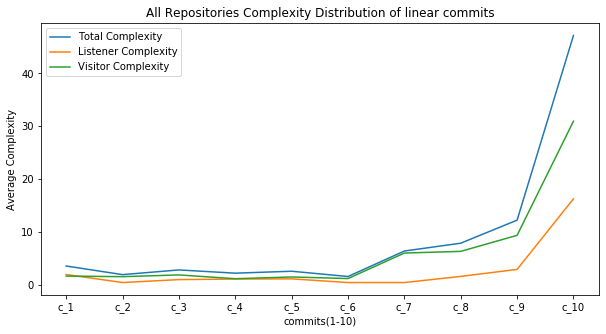

In [45]:
x_values = ['c_'+str(value) for value in avg_commit_comp_df['commit_group_id']]
plot_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values, "commits(1-10)", "Average Complexity", "All Repositories Complexity Distribution of linear commits")

In [ ]:
x_values_bar_graph = ['C_6_7_8', 'C_9_10', 'Complexity_shift']
